In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt

In [5]:
import zipfile

src_path = "/content/Data.zip"
# Unzip the file to a specific destination
with zipfile.ZipFile(src_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [6]:
im_array = []
mask_array = []
X_shape = 256

folders = [f for f in os.listdir('Data')]

for folder in tqdm(folders):
  patient_path = f"Data/{folder}"
  ids = [i for i in os.listdir(patient_path + "/Mask")]

  for id in ids:
    image_path = patient_path + "/Without Mask"
    mask_path = patient_path + "/NMask"
    im = cv2.resize(cv2.imread(os.path.join(image_path, f"{id}")),(X_shape,X_shape))[:,:,0]
    mask = cv2.resize(cv2.imread(os.path.join(mask_path, f"{id}"), cv2.IMREAD_GRAYSCALE), (X_shape, X_shape))
    mask_array.append(mask)
    im_array.append(im)


100%|██████████| 15/15 [00:02<00:00,  5.80it/s]


In [7]:
im = []
for image in im_array:
  fil = cv2.adaptiveThreshold(image , 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11 ,2)
  im.append(fil)

im_array = []
im_array = im

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming im_array and mask_array are NumPy arrays
im_array = np.array(im_array)
mask_array = np.array(mask_array)

# Normalize the image data
im_array_normalized = (im_array - 127.0 ) / 127.0

# Binarize the mask data
mask_array_binary = (mask_array > 190).astype(np.float32)

# Split the data
train_vol, test_vol, train_seg, test_seg = train_test_split(im_array_normalized, mask_array_binary, test_size=0.1, random_state=2018)
train_vol, validation_vol, train_seg, validation_seg = train_test_split(train_vol, train_seg, test_size=0.1, random_state=2018)

train_vol = train_vol.astype(np.float32)
train_seg = train_seg.astype(np.float32)
test_vol = test_vol.astype(np.float32)
test_seg = test_seg.astype(np.float32)

train_vol = np.expand_dims(train_vol, axis=-1)
validation_vol = np.expand_dims(validation_vol, axis=-1)
test_vol = np.expand_dims(test_vol, axis=-1)

# Add channel dimension to label data
train_seg = np.expand_dims(train_seg, axis=-1)
validation_seg = np.expand_dims(validation_seg, axis=-1)
test_seg = np.expand_dims(test_seg, axis=-1)

In [9]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  smooth = 1.0  # Smoothing factor to avoid division by zero
  intersection = K.sum(K.flatten(y_true * y_pred))
  union = K.sum(K.flatten(y_true)) + K.sum(K.flatten(y_pred)) - intersection
  return 1 - ( 2.*intersection) / (union)

In [10]:
import tensorflow as tf
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    dice = K.mean((intersection) / (union))
    return dice

# def dice_loss(y_true, y_pred):
#     return 1 - dice_coefficient(y_true, y_pred)

In [6]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [7]:
yt = cv2.imread('/content/original.jpg',cv2.IMREAD_GRAYSCALE)
yp = cv2.imread('/content/predicted.jpg',cv2.IMREAD_GRAYSCALE)

print(dice_coefficient(yt, yp))
print(dice_loss(yt,yp))


tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)


In [2]:
import tensorflow as tf
tf.random.set_seed(42)

im_wid = 256
im_hig = 256
channel = 1

input = tf.keras.layers.Input((im_wid, im_hig, channel))
s = tf.keras.layers.Lambda(lambda x: x/255)(input)
# s = tf.keras.layers.Normalization(axis=-1)(input)

c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)


u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128*2, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)

output = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(c9)

model = tf.keras.Model(inputs = [input], outputs = [output])
model.compile(optimizer = 'adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])
# model.compile(optimizer = 'adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        160 │ lambda_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_12[0][0]

 Total params: 2,383,313 (9.09 MB)

 Trainable params: 2,383,313 (9.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

def convblock(filters, input):
    c1 = tf.keras.layers.Conv2D(filters, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(input)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(filters, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)\
    
    return c1

im_wid = 256
im_hig = 256
channel = 1

input = tf.keras.layers.Input((im_wid, im_hig, channel))
s = tf.keras.layers.Lambda(lambda x: x/255)(input)



c00 = convblock(16, s)
p00 = tf.keras.layers.MaxPooling2D((2,2))(c00)

c10 = convblock(32, p00)
p10 = tf.keras.layers.MaxPooling2D((2,2))(c10)
u10 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(c10)

i01 = tf.keras.layers.concatenate([u10, c00])
c01 = convblock(16, i01)
output1 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c01)

c20 = convblock(64, p10)
p20 = tf.keras.layers.MaxPooling2D((2,2))(c20)
u20 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(c20)

i11 = tf.keras.layers.concatenate([u20, c10])
c11 = convblock(32, i11)
u11 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(c11)

i02 = tf.keras.layers.concatenate([u11, c01, c00])
c02 = convblock(16, i02)
output2 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c02)

c30 = convblock(128, p20)
p30 = tf.keras.layers.MaxPooling2D((2,2))(c30)
u30 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c30)

i21 = tf.keras.layers.concatenate([u30, c20])
c21 = convblock(64, i21)
u21 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c21)

i12 = tf.keras.layers.concatenate([u21, c10, c11])
c12 = convblock(32, i12)
u12 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c12)

i03 = tf.keras.layers.concatenate([u12, c00, c01, c02])
c03 = convblock(16, i03)
output3 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c03)

c40 = convblock(256, p30)
u40 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(c40)

i31 = tf.keras.layers.concatenate([u40, c30])
c31 = convblock(128, i31)
u31 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c31)

i22 = tf.keras.layers.concatenate([u31, c20, c21])
c22 = convblock(64, i22)
u22 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(c22)

i13 = tf.keras.layers.concatenate([u22, c10, c11, c12])
c13 = convblock(32, i13)
u13 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(c13)

i04 = tf.keras.layers.concatenate([u13, c00, c01, c02, c03])
c04 = convblock(16, i04)
output4 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c04)

model = tf.keras.Model(inputs=[input], outputs=[output1, output2, output3, output4])
model.compile(optimizer = 'adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics = [dice_coefficient])
model.summary()

In [12]:
callbacks = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss')

In [ ]:
results = model.fit(train_vol, train_seg, validation_data =(validation_vol,validation_seg), batch_size=10, epochs=80, callbacks = callbacks)

In [9]:
preds = model.predict(test_vol)

3/3 [==============================] - 6s 734ms/step


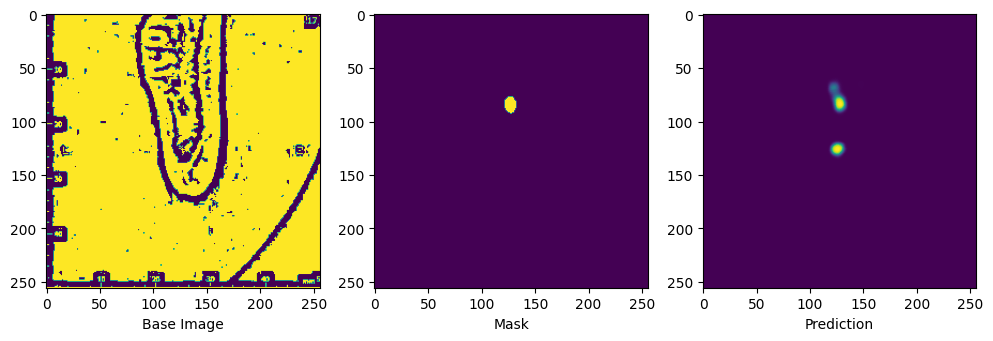

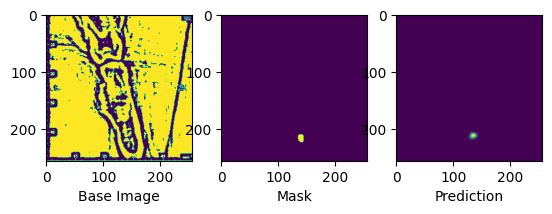

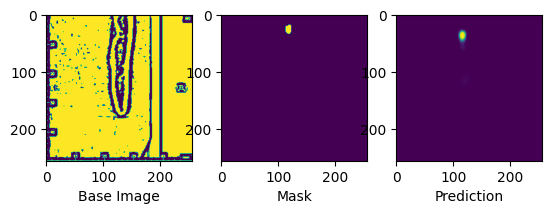

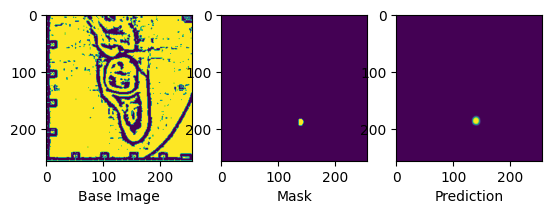

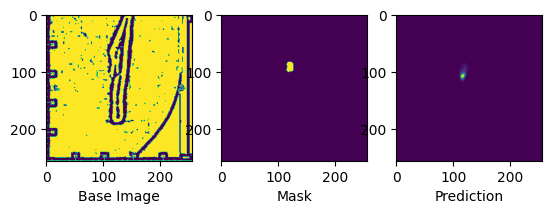

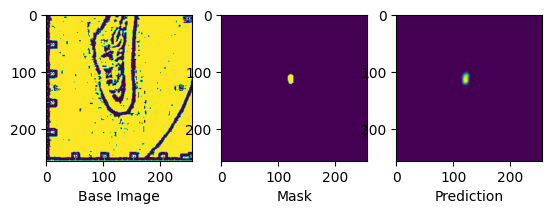

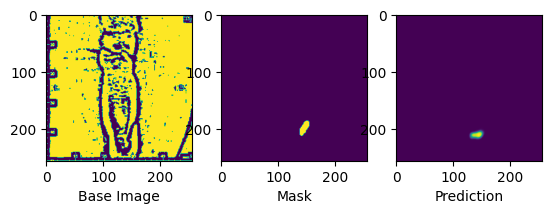

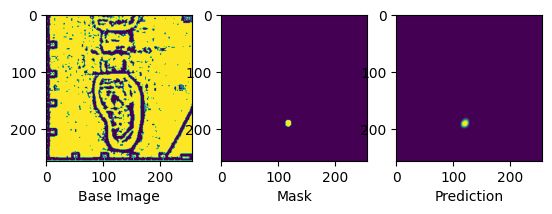

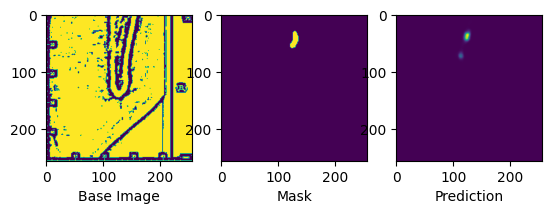

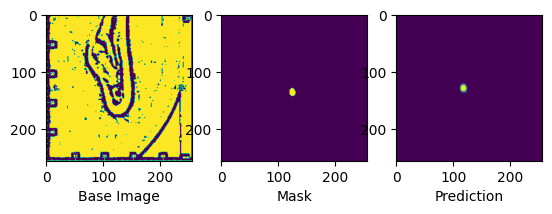

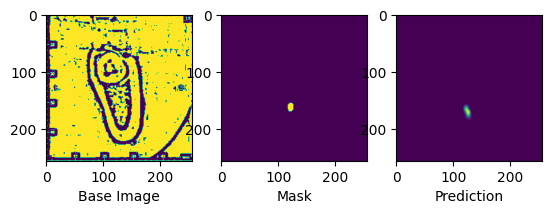

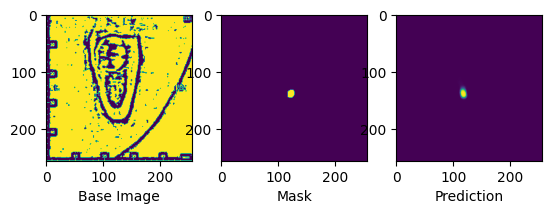

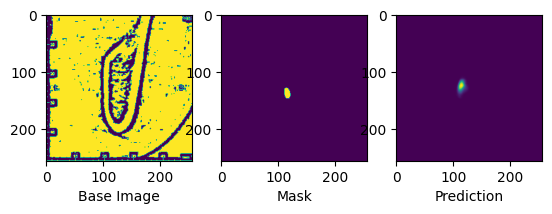

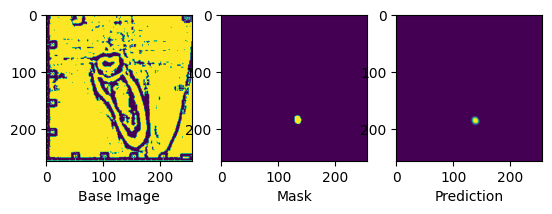

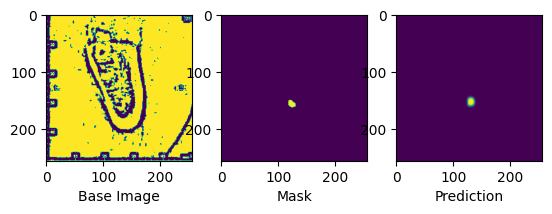

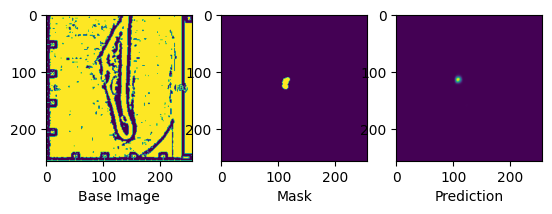

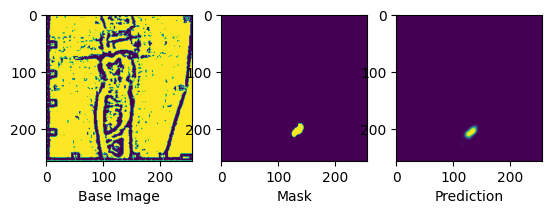

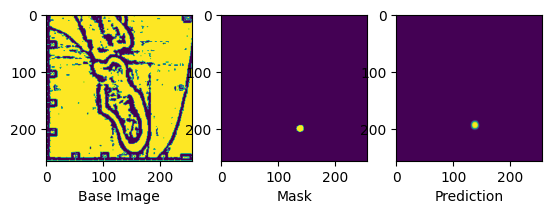

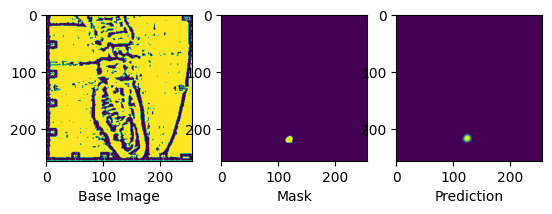

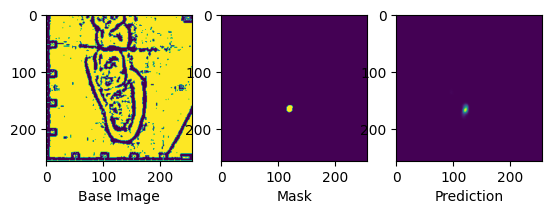

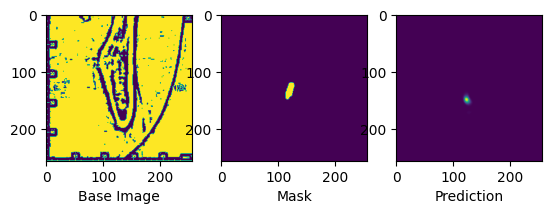

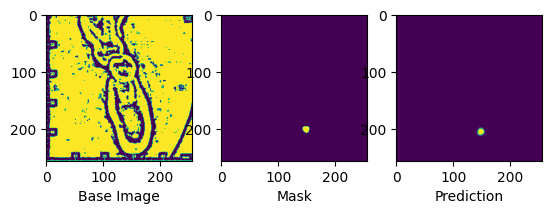

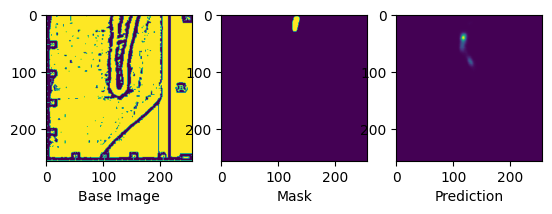

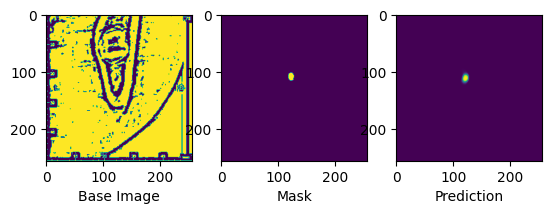

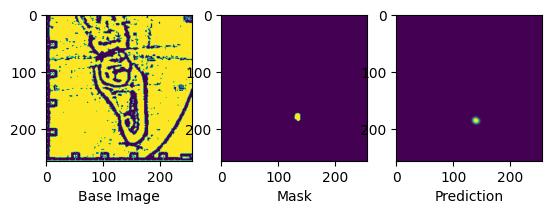

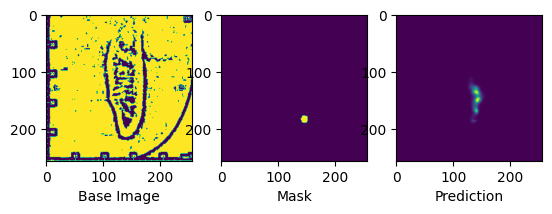

In [ ]:
plt.figure(figsize=(12, 4))

for p in range(len(test_vol)):
  # Plot the base image
  plt.subplot(1, 3, 1)
  plt.imshow(np.squeeze(test_vol[p]))
  plt.xlabel("Base Image")

  # Plot the ground truth mask
  plt.subplot(1, 3, 2)
  plt.imshow(np.squeeze(test_seg[p]))
  plt.xlabel("Mask")

  # Plot the predicted mask for the 8th sample
  plt.subplot(1, 3, 3)
  plt.imshow(np.squeeze(preds[p]))  # Use the index directly
  plt.xlabel("Prediction")

  plt.show()

In [ ]:
cv2.imwrite('Original1.jpg', (test_vol[1]*127 + 127))
cv2.imwrite('Mask1.jpg', test_seg[1]*250)
cv2.imwrite('Pred1.jpg', preds[1]*250)
cv2.imwrite('Original2.jpg', (test_vol[10]*127 + 127))
cv2.imwrite('Mask2.jpg', test_seg[10]*250)
cv2.imwrite('Pred2.jpg', preds[10]*250)


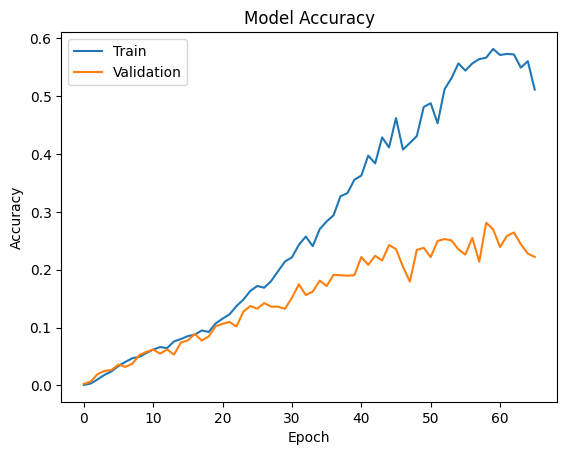

In [15]:
plt.plot(results.history['dice_coefficient'])
plt.plot(results.history['val_dice_coefficient'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()